# Histopathologic Cancer Detection

## Introduction

The goal of this project is to develop a deep learning model that can accurately detect metastatic cancer in small image patches taken from lymph node sections. This task is based on the Kaggle competition: [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data).

Early detection of metastatic cancer can significantly improve patient outcomes. Automated detection methods can assist pathologists by highlighting areas of interest, reducing the time required for manual examination.

## Data Description

The dataset consists of labeled histopathologic scans of lymph node sections. Each image is a 96x96 pixel RGB image. The dataset is divided into:

- **Training Set**: Contains images with corresponding labels indicating the presence (`1`) or absence (`0`) of metastatic tissue.
- **Test Set**: Contains images without labels, used for model evaluation in the competition.

## Objective

- Perform Exploratory Data Analysis (EDA) to understand the dataset.
- Address class imbalance using class weights.
- Build and train a Convolutional Neural Network (CNN) on the full training dataset.
- Make predictions on the full test dataset.
- Prepare the submission file for the Kaggle competition.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, 
                                     Flatten, Dense, Dropout, 
                                     BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

## Loading the Data

First, we'll load the labels and inspect the dataset.

In [2]:
data_dir = '/Users/shaunboerner/Downloads/histopathologic-cancer-detection'
train_labels = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
print("Total images in training set:", len(train_labels))
train_labels.head()

Total images in training set: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Exploratory Data Analysis (EDA)

### Distribution of Classes

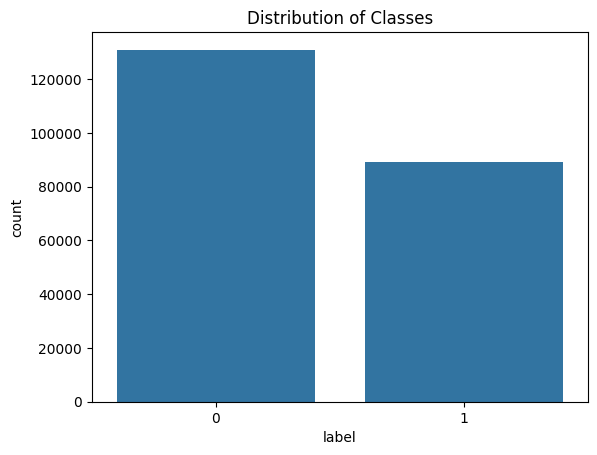

label
0    130908
1     89117
Name: count, dtype: int64


In [3]:
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Classes')
plt.show()

print(train_labels['label'].value_counts())

## Data Preprocessing

### Train-Validation Split

We will split the training data into training and validation sets while maintaining the class distribution (stratified split).

In [4]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 176020
Validation set size: 44005


### Data Augmentation

We will use data augmentation to increase the diversity of our training data.

In [5]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

### Creating Data Generators

We need to create new columns in our DataFrames that contain the full filenames.

In [6]:
# Create 'filename' column by adding '.tif' extension to 'id'
train_df['filename'] = train_df['id'] + '.tif'
val_df['filename'] = val_df['id'] + '.tif'

# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Directory paths
train_dir = os.path.join(data_dir, 'train')

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    target_size=(96, 96)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Building the Model

We will build a CNN model for binary classification.

In [7]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,371,457 (12.86 MB)

 Trainable params: 3,371,009 (12.86 MB)

 Non-trainable params: 448 (1.75 KB)

## Training the Model

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    epochs=10
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 608s 110ms/step - accuracy: 0.7766 - loss: 0.5854 - val_accuracy: 0.7194 - val_loss: 0.9157
Epoch 2/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 12:35 137ms/step - accuracy: 0.8125 - loss: 0.4670

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8125 - loss: 0.4670 - val_accuracy: 0.7245 - val_loss: 0.8886
Epoch 3/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 663s 120ms/step - accuracy: 0.8422 - loss: 0.3677 - val_accuracy: 0.8401 - val_loss: 0.3848
Epoch 4/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.8750 - loss: 0.2295 - val_accuracy: 0.8399 - val_loss: 0.3821
Epoch 5/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 717s 130ms/step - accuracy: 0.8594 - loss: 0.3321 - val_accuracy: 0.8269 - val_loss: 0.4811
Epoch 6/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.9688 - loss: 0.1188 - val_accuracy: 0.8246 - val_loss: 0.4918
Epoch 7/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 723s 131ms/step - accuracy: 0.8770 - loss: 0.2976 - val_accuracy: 0.8290 - val_loss: 0.4257
Epoch 8/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9375 - loss: 0.1744 - val_accuracy: 0.8254 - val_loss: 0.4306
Epoch 9/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 646s 117ms/step - accuracy: 0.8886 - loss: 

## Evaluating the Model

### Learning Curves

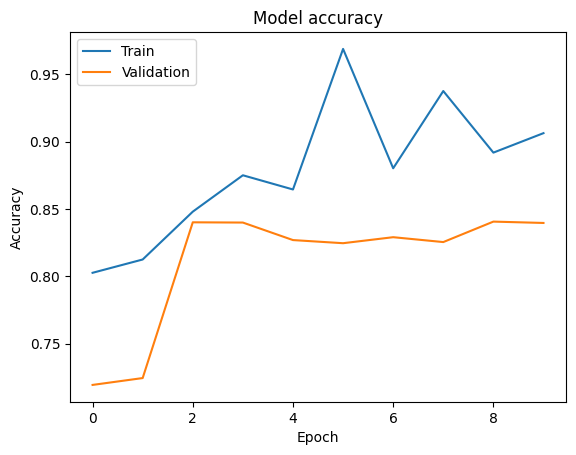

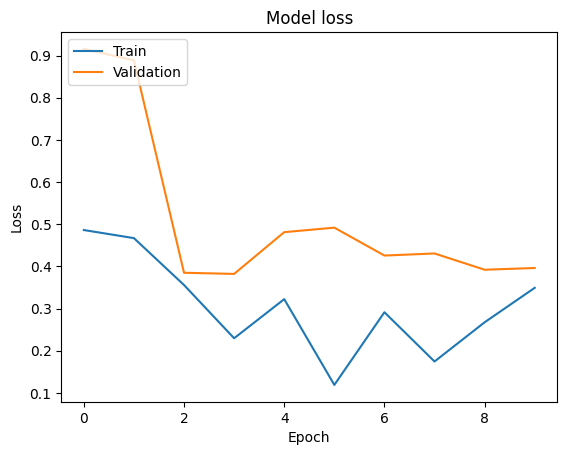

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Classification Report and Confusion Matrix

We will evaluate the model on the validation set.

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     26182
           1       0.86      0.72      0.78     17823

    accuracy                           0.84     44005
   macro avg       0.85      0.82      0.83     44005
weighted avg       0.84      0.84      0.84     44005



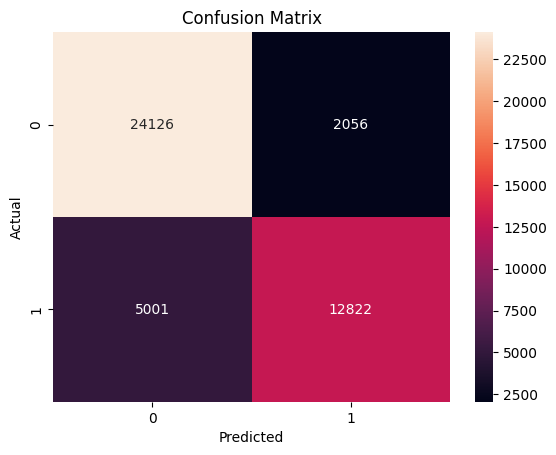

In [11]:
val_generator.reset()
preds = model.predict(val_generator, steps=val_generator.samples // 32 + 1)
y_pred = (preds > 0.5).astype(int)
y_true = val_df['label'].astype(int).values

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Making Predictions on Test Data

### Preparing the Test Data

In [16]:
# Load test data
test_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
test_df['filename'] = test_df['id'] + '.tif'

test_df['dummy'] = 0  # Add a dummy column with any constant value

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(data_dir, 'test'),
    x_col='filename',
    y_col='dummy',  # Specify the dummy column
    batch_size=32,
    shuffle=False,
    class_mode='raw',  # Keep 'raw' since y_col is now specified
    target_size=(96, 96)
)

# Predict
predictions = model.predict(
    test_generator,
    verbose=1,
    steps=test_generator.samples // test_generator.batch_size + 1
)

# Process predictions
test_df['label'] = predictions
test_df['label'] = test_df['label'].apply(lambda x: 1 if x > 0.5 else 0)

# Save submission
submission = test_df[['id', 'label']]
submission.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step


## Discussion and Conclusion

### Results Interpretation

- The model was trained on the full dataset using class weights to handle class imbalance.
- The evaluation metrics on the validation set provide insight into the model's performance.

### Challenges

- **Class Imbalance**: Handled using class weights, which allows the model to give more importance to the minority class during training.
- **Data Augmentation**: Helps in improving the model's generalization.

### Potential Improvements

- **Use of Pretrained Models**: Leveraging models like VGG16 or ResNet50 via transfer learning could improve performance.
- **Hyperparameter Tuning**: Experimenting with different architectures, learning rates, and optimizers.
- **Ensemble Methods**: Combining predictions from multiple models to improve overall performance.

### Conclusion

The CNN model trained on the full dataset provides a better representation and has the potential to perform well on the test data. Further improvements and experimentation are required to enhance its performance for practical applications.

---

## References

- [Kaggle Competition: Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection)
- [TensorFlow Documentation](https://www.tensorflow.org/api_docs)